# Step 0. Install dependencies

In [82]:
#Install dependencies
# !pip install transformers[torch]
# !pip install accelerate -U
# !pip install datasets
# !pip install torchinfo

# Step 1. EDA

In [83]:
%load_ext autoreload
%autoreload 2
#Import dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset

## Class for dealing to data sets
from src.DatasetManager import DatasetManager
## Class for dealing models
from src.ModelManager import ModelManager
## Class for dealing with common dataset processing tasks
from src.DatasetProcesser import DatasetProcessor, HFprocesser

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
dataset_manager = DatasetManager()
financial_news = dataset_manager.get_financial_news() #read csv set header to none because columns have no title


In [85]:
#Check DF head and Tail
financial_news.head()
financial_news.tail()

,label,news
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...
4845,negative,Sales in Finland decreased by 10.5 % in Januar...


In [86]:
#Check shape of train df
financial_news.shape

(4846, 2)

In [87]:
#Check information of df
#we can see there is no missing values
financial_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   news    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


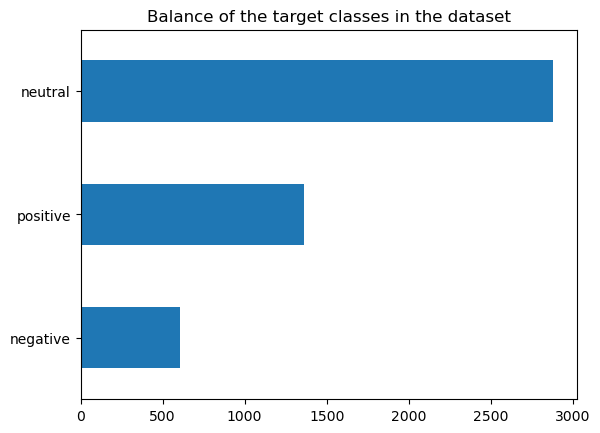

neutral     2879
positive    1363
negative     604
Name: label, dtype: int64


In [88]:
#Check balance of the data set
dataset_manager.plot_external(financial_news)

#We can notice that the data set is imbalanced


In [89]:
print(dataset_manager.check_doc_len(financial_news))

81


In [90]:
financial_news.drop(columns={'len'}, inplace=True)
financial_news.head(3)

,label,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...


# Step 2. Pre-processing

### Approach 1. do not balance classes

In [91]:
#First let's map the labels to integers
fin_news_preprocessor = DatasetProcessor(financial_news)
label_map = {'negative': 2, 'neutral': 0, 'positive': 1}

fin_news_preprocessor.map_labels(label_map)

#The preprocessors df can directly be used thanks to __getattr__ method
fin_news_preprocessor.head()

,label,news
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,1,With the new production plant the company woul...
4,1,According to the company 's updated strategy f...


In [92]:
#Save approach 1 dataframe to folder
financial_news.to_csv('data/financial_news_1.csv', index=False)

### Approach 2. Downsampling

In [93]:
# Let's downsample positive and neutral labels to create a balanced data set

financial_news_ds = dataset_manager.get_financial_news() 
fin_news_preprocessor = DatasetProcessor(financial_news_ds)
fin_news_preprocessor.map_labels()

#Now let's separate our 3 classes to perform downsample
financial_news_n,financial_news_0,financial_news_1 = fin_news_preprocessor.seperate_labels_classes()



In [94]:
#Check separated labels
financial_news_n['label'].unique()
financial_news_0['label'].unique()
financial_news_1['label'].unique()

array([1], dtype=int64)

In [95]:
#Downsample positive and neutral labels to be same length as negative label
financial_news_0, financial_news_1 = fin_news_preprocessor.downsample_labels(financial_news_n, financial_news_0, financial_news_1)


In [96]:
#Check shapes
financial_news_0['label'].shape
financial_news_1['label'].shape

(604,)

In [97]:
#put everything together again
#shuffle rows and reset index
financial_news_ds = fin_news_preprocessor.shuffle_and_reset([financial_news_n, financial_news_0, financial_news_1])

#check df
financial_news_ds.tail()

,label,news
1807,0,The Russian government will contribute 20 % of...
1808,1,"In the fourth quarter of 2008 , net sales incr..."
1809,0,The Estonian beverages maker A. Le Coq today b...
1810,1,Satama 's net profit for the third quarter of ...
1811,0,The reason for this is St. Petersburg status a...


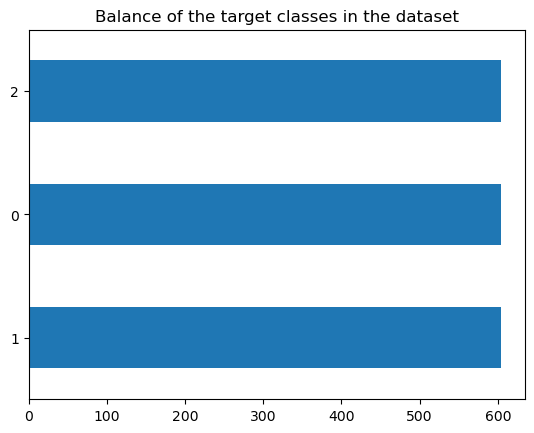

1    604
0    604
2    604
Name: label, dtype: int64


In [98]:
#Check balance of the data set

dataset_manager.plot_external(financial_news_ds)

#We can notice that the data set is balanced

In [99]:
#save approach 2 dataframe
financial_news_ds.to_csv('financial_news_2.csv', index=False)

# Step 3. Feature extraction

## Feature Extraction for Transfer Learning

In [130]:
from src.HFManager import HFManager
from src.DatasetProcesser import HFprocesser

# create datasets to be used with hugging face
dataset_manager.create_dataset('balanced_dataset', 'data/financial_news_2.csv')
dataset_manager.create_dataset('imbalanced_dataset', 'data/financial_news_1.csv')

## Load the dataset which is a hugging face
HFproc_balanced_dataset = HFprocesser(dataset_manager.get_dataset('balanced_dataset'))
HFproc_imbalanced_dataset = HFprocesser(dataset_manager.get_dataset('imbalanced_dataset'))

## Create train val train dict using hugging faces built in dataset\
hf_tvt_dict_balanced = HFproc_balanced_dataset.create_train_test_val_splits()
hf_tvt_dict_imbalanced = HFproc_imbalanced_dataset.create_train_test_val_splits()



Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/Rober/.cache/huggingface/datasets/csv/default-30cde7412fe4eeeb/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to C:/Users/Rober/.cache/huggingface/datasets/csv/default-3418566d11967f2a/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [131]:
#Check raw data sets
hf_tvt_dict_balanced


DatasetDict({
    train: Dataset({
        features: ['label', 'news'],
        num_rows: 1449
    })
    test: Dataset({
        features: ['label', 'news'],
        num_rows: 217
    })
    valid: Dataset({
        features: ['label', 'news'],
        num_rows: 146
    })
})

In [132]:
hf_tvt_dict_imbalanced

DatasetDict({
    train: Dataset({
        features: ['label', 'news', 'len'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['label', 'news', 'len'],
        num_rows: 582
    })
    valid: Dataset({
        features: ['label', 'news', 'len'],
        num_rows: 388
    })
})

In [133]:
# For fine tuning a pre trained model we are choosing to use distilBERT since it's lighter than other BERT based models while conserving the vast majority of BERT's performance

HFproc_balanced_dataset.tokenize_text_data() # stores tokenized test data in class attribute
HFproc_imbalanced_dataset.tokenize_text_data() # stores tokenized test data in class attribute


Map:   0%|          | 0/1449 [00:00<?, ? examples/s]

Map:   0%|          | 0/217 [00:00<?, ? examples/s]

Map:   0%|          | 0/146 [00:00<?, ? examples/s]

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/582 [00:00<?, ? examples/s]

Map:   0%|          | 0/388 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'news', 'len', 'input_ids', 'attention_mask'],
        num_rows: 3876
    })
    test: Dataset({
        features: ['label', 'news', 'len', 'input_ids', 'attention_mask'],
        num_rows: 582
    })
    valid: Dataset({
        features: ['label', 'news', 'len', 'input_ids', 'attention_mask'],
        num_rows: 388
    })
})

# Step 4. Training

### Approach 1. Fine Tune pre-trained distilBERT model

In [146]:
#import bert model
#AutomodelForSequenceClassification will give us a model that already has some classification layers on top of distilbert
#Trainer is a class that help us train transformers, TrainingArguments is used to define training arguments in Trainer


## Init the hugging face mananger whice also downloads the model
huggingface_manager = HFManager("distilbert/distilbert-base-uncased")
## add a model
huggingface_manager.add_model('main')
huggingface_manager.add_model('frozen')



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
#Check trainable layers of the model
huggingface_manager.get_trainable_layers('frozen')


distilbert.embeddings.word_embeddings.weight True
distilbert.embeddings.position_embeddings.weight True
distilbert.embeddings.LayerNorm.weight True
distilbert.embeddings.LayerNorm.bias True
distilbert.transformer.layer.0.attention.q_lin.weight True
distilbert.transformer.layer.0.attention.q_lin.bias True
distilbert.transformer.layer.0.attention.k_lin.weight True
distilbert.transformer.layer.0.attention.k_lin.bias True
distilbert.transformer.layer.0.attention.v_lin.weight True
distilbert.transformer.layer.0.attention.v_lin.bias True
distilbert.transformer.layer.0.attention.out_lin.weight True
distilbert.transformer.layer.0.attention.out_lin.bias True
distilbert.transformer.layer.0.sa_layer_norm.weight True
distilbert.transformer.layer.0.sa_layer_norm.bias True
distilbert.transformer.layer.0.ffn.lin1.weight True
distilbert.transformer.layer.0.ffn.lin1.bias True
distilbert.transformer.layer.0.ffn.lin2.weight True
distilbert.transformer.layer.0.ffn.lin2.bias True
distilbert.transformer.lay

In [148]:
#Freeze all distilbert layers
huggingface_manager.freeze_layers('frozen')

In [149]:
#Check again trainable and non trainable layers

huggingface_manager.get_trainable_layers('frozen')


distilbert.embeddings.word_embeddings.weight False
distilbert.embeddings.position_embeddings.weight False
distilbert.embeddings.LayerNorm.weight False
distilbert.embeddings.LayerNorm.bias False
distilbert.transformer.layer.0.attention.q_lin.weight False
distilbert.transformer.layer.0.attention.q_lin.bias False
distilbert.transformer.layer.0.attention.k_lin.weight False
distilbert.transformer.layer.0.attention.k_lin.bias False
distilbert.transformer.layer.0.attention.v_lin.weight False
distilbert.transformer.layer.0.attention.v_lin.bias False
distilbert.transformer.layer.0.attention.out_lin.weight False
distilbert.transformer.layer.0.attention.out_lin.bias False
distilbert.transformer.layer.0.sa_layer_norm.weight False
distilbert.transformer.layer.0.sa_layer_norm.bias False
distilbert.transformer.layer.0.ffn.lin1.weight False
distilbert.transformer.layer.0.ffn.lin1.bias False
distilbert.transformer.layer.0.ffn.lin2.weight False
distilbert.transformer.layer.0.ffn.lin2.bias False
distilbe

In [155]:
# Compile model
# model with frozen layers and imbalanced dataset
huggingface_manager.add_trainer(
    "frozen","frozen_imbalanced", HFproc_imbalanced_dataset
)
# model with frozen layers and balanced dataset
huggingface_manager.add_trainer("frozen","frozen_balanced", HFproc_balanced_dataset)
# full trainable model and imbalanced dataset
huggingface_manager.add_trainer("main","main_imbalanced", HFproc_imbalanced_dataset)
# full trainable model and balanced dataset
huggingface_manager.add_trainer("main","main_balanced", HFproc_balanced_dataset)

In [157]:
huggingface_manager.trainers

{'frozen_imbalanced': <transformers.trainer.Trainer at 0x1c3018be690>,
 'frozen_balanced': <transformers.trainer.Trainer at 0x1c300f9e290>,
 'main_imbalanced': <transformers.trainer.Trainer at 0x1c3e5054950>,
 'main_balanced': <transformers.trainer.Trainer at 0x1c3e51e84d0>}

In [ ]:
#Train model and measure time
# fully trainable model and imbalanced dataset
huggingface_manager.train_trainer('main_imbalanced')


{'eval_loss': 0.42063993215560913, 'eval_accuracy': 0.8195876288659794, 'eval_f1': 0.822524545317873, 'eval_runtime': 1.17, 'eval_samples_per_second': 331.627, 'eval_steps_per_second': 5.983, 'epoch': 1.0}
{'eval_loss': 0.4005722999572754, 'eval_accuracy': 0.8350515463917526, 'eval_f1': 0.8361486368160397, 'eval_runtime': 1.1614, 'eval_samples_per_second': 334.078, 'eval_steps_per_second': 6.027, 'epoch': 2.0}
{'loss': 0.384, 'learning_rate': 1.570644718792867e-05, 'epoch': 2.06}
{'eval_loss': 0.5161873698234558, 'eval_accuracy': 0.8298969072164949, 'eval_f1': 0.8309416387147296, 'eval_runtime': 1.1694, 'eval_samples_per_second': 331.796, 'eval_steps_per_second': 5.986, 'epoch': 3.0}
{'train_runtime': 162.2176, 'train_samples_per_second': 71.681, 'train_steps_per_second': 4.494, 'train_loss': 0.29950033588173947, 'epoch': 3.0}
Training execution time  -0.003429329000027792 2


In [ ]:
#Train model and measure time
# fully trainable model and imbalanced dataset
huggingface_manager.train_trainer('main_balanced')


{'eval_loss': 0.16250543296337128, 'eval_accuracy': 0.952054794520548, 'eval_f1': 0.9523733585428641, 'eval_runtime': 0.3, 'eval_samples_per_second': 486.695, 'eval_steps_per_second': 10.001, 'epoch': 1.0}
{'eval_loss': 0.18538278341293335, 'eval_accuracy': 0.9657534246575342, 'eval_f1': 0.9657513699050086, 'eval_runtime': 0.3097, 'eval_samples_per_second': 471.449, 'eval_steps_per_second': 9.687, 'epoch': 2.0}
{'eval_loss': 0.18359039723873138, 'eval_accuracy': 0.9726027397260274, 'eval_f1': 0.9726186240374108, 'eval_runtime': 0.3017, 'eval_samples_per_second': 483.959, 'eval_steps_per_second': 9.944, 'epoch': 3.0}
{'train_runtime': 41.3616, 'train_samples_per_second': 105.097, 'train_steps_per_second': 6.6, 'train_loss': 0.09551458393697773, 'epoch': 3.0}
Training execution time  42.25369381904602 2


In [ ]:
#Train model and measure time
# fully trainable model and imbalanced dataset
huggingface_manager.train_trainer('main_imbalanced')


{'eval_loss': 0.42063993215560913, 'eval_accuracy': 0.8195876288659794, 'eval_f1': 0.822524545317873, 'eval_runtime': 1.17, 'eval_samples_per_second': 331.627, 'eval_steps_per_second': 5.983, 'epoch': 1.0}
{'eval_loss': 0.4005722999572754, 'eval_accuracy': 0.8350515463917526, 'eval_f1': 0.8361486368160397, 'eval_runtime': 1.1614, 'eval_samples_per_second': 334.078, 'eval_steps_per_second': 6.027, 'epoch': 2.0}
{'loss': 0.384, 'learning_rate': 1.570644718792867e-05, 'epoch': 2.06}
{'eval_loss': 0.5161873698234558, 'eval_accuracy': 0.8298969072164949, 'eval_f1': 0.8309416387147296, 'eval_runtime': 1.1694, 'eval_samples_per_second': 331.796, 'eval_steps_per_second': 5.986, 'epoch': 3.0}
{'train_runtime': 162.2176, 'train_samples_per_second': 71.681, 'train_steps_per_second': 4.494, 'train_loss': 0.29950033588173947, 'epoch': 3.0}
Training execution time  -0.003429329000027792 2


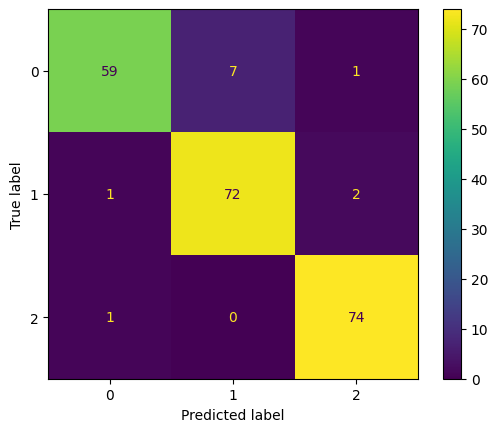

In [ ]:
huggingface_manager.plot_prediction('main_balanced',HFproc_balanced_dataset.tokenized_text_data)

In [ ]:
huggingface_manager.print_eval('main_balanced',HFproc_balanced_dataset.tokenized_text_data)